# 적층 오토인코더

적층 오토인코더: 가운데 은닉층을 기준으로 여러개의 층을 가지는 오토인코더

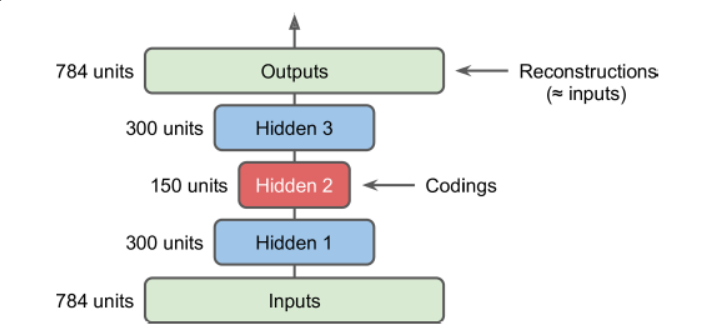

##  17.3.1 케라스를 사용하여 적층 오토인코더 구현하기

In [ ]:
from tensorflow import keras
import numpy as np

패션 MNIST 데이터셋 적재

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

4431872/4422102 [==============================] - 0s 0us/step


In [ ]:
stacked_encoder = keras.models.Sequential([
  keras.layers.Flatten(input_shape=[28,28]),
  keras.layers.Dense(300, activation="selu"),
  keras.layers.Dense(150, activation="selu")                                   
])

stacked_decoder = keras.models.Sequential([
  keras.layers.Dense(300, activation="selu", input_shape=[150]),
  keras.layers.Dense(28 *28, activation="sigmoid"),
  #이미지 Shape 복원
  keras.layers.Reshape([28,28])                                   
])

stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.5))
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3352 - val_loss: 0.3157
Epoch 2/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3042 - val_loss: 0.3006
Epoch 3/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2972 - val_loss: 0.2983
Epoch 4/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2932 - val_loss: 0.2933
Epoch 5/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2905 - val_loss: 0.2903
Epoch 6/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2886 - val_loss: 0.2889
Epoch 7/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2873 - val_loss: 0.2922
Epoch 8/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2862 - val_loss: 0.2867
Epoch 9/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2852 - val_loss: 0.2860
Epoch 10/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.284

## 17.3.2 재구성 시각화

In [ ]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [ ]:
def plot_image(image):
  plt.imshow(image, cmap="binary")
  plt.axis("off")
  
# 결과물 시각화
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

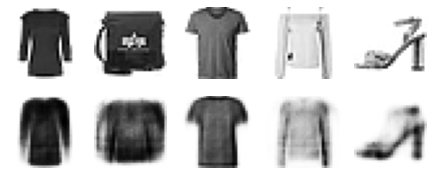

In [ ]:
show_reconstructions(stacked_ae)



*   이미지 식별 가능하지만, 정보를 많이 잃음
*   모델을 깊게하여 정보 유실 방지



## 17.3.3 패션 MNIST 데이터셋 시각화

훈련한 적층 오토인코더 모델을 통해 데이터셋 차원 축소에 용이 

In [ ]:
np.random.seed(42)

from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


SNE: 학습 과정에서 가우시안 분포를 이용하여 n차원에 분포된 이산 데이터 간의 거리 정보를 유지하며 k차원으로 축소

t-SNE: 가우시안 분포 대신 t분포 이용

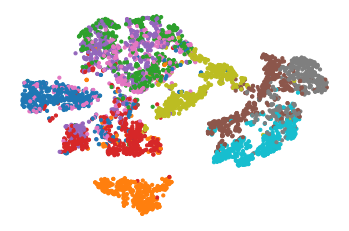

In [ ]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.axis("off")
plt.show()

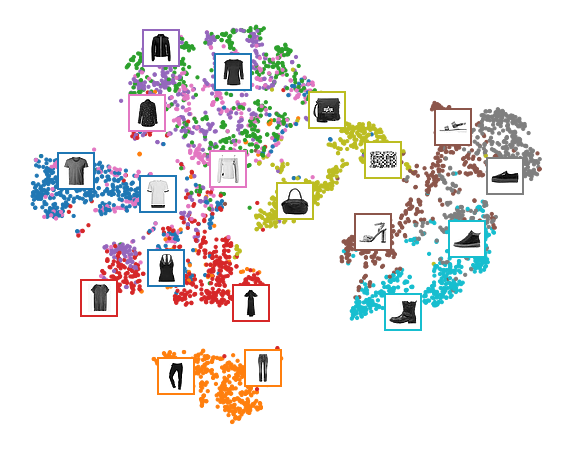

In [ ]:
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: 
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

## 17.3.5 가중치 묶기

적층 오토인코더의 모델이 대칭일 경우, decoder의 가중치와 encoder의 가중치를 묶을 수 있다!


*   훈련 속도 Up!
*   과대적합 위험 Down!



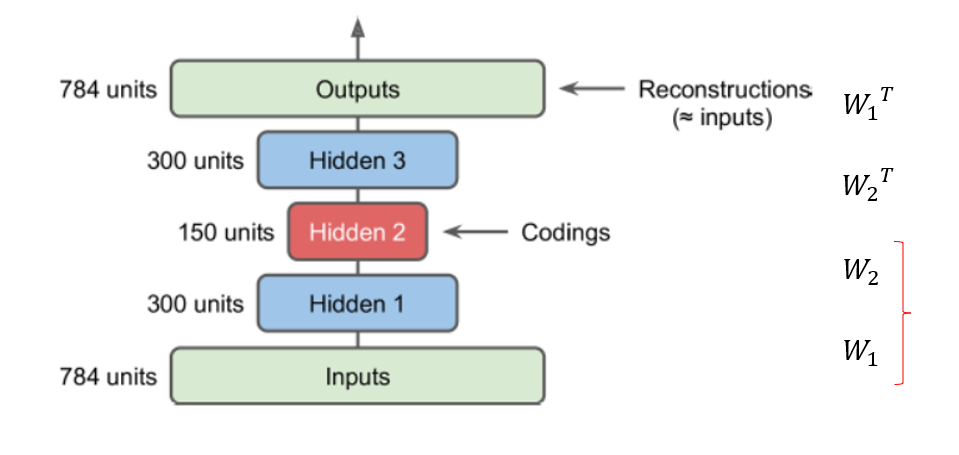

In [ ]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=[self.dense.input_shape[-1]],
                                      initializer="zeros")
        super().build(batch_input_shape)
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

In [ ]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [ ]:
import tensorflow as tf
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

dense_1 = keras.layers.Dense(100, activation="selu")
dense_2 = keras.layers.Dense(30, activation="selu")

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    dense_1,
    dense_2
])

tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation="selu"),
    DenseTranspose(dense_1, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])

tied_ae.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])
history = tied_ae.fit(X_train, X_train, epochs=10,
                      validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3269 - rounded_accuracy: 0.8960 - val_loss: 0.3080 - val_rounded_accuracy: 0.9081
Epoch 2/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2975 - rounded_accuracy: 0.9224 - val_loss: 0.2953 - val_rounded_accuracy: 0.9284
Epoch 3/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2920 - rounded_accuracy: 0.9274 - val_loss: 0.3022 - val_rounded_accuracy: 0.9078
Epoch 4/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.2889 - rounded_accuracy: 0.9301 - val_loss: 0.2880 - val_rounded_accuracy: 0.9332
Epoch 5/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.2865 - rounded_accuracy: 0.9325 - val_loss: 0.2876 - val_rounded_accuracy: 0.9308
Epoch 6/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.2850 - rounded_accuracy: 0.9340 - val_loss: 0.2861 - val_rounded_accuracy: 0.9353
Epoch 7/10
1719/1719 [===============

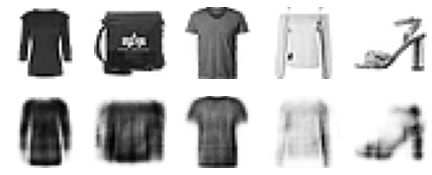

In [ ]:
show_reconstructions(tied_ae)
plt.show()

## 17.3.6 한 번에 오토인코더 한 개씩 훈련하기

오토인코더를 하나 훈련하고 이를 쌓아올려서 한 개의 적층 오토인코더를 만들 수 있다

*   현재는 많이 사용하지 않음
*   탐욕적 방식의 층별 훈련은 논문에 여전히 등장



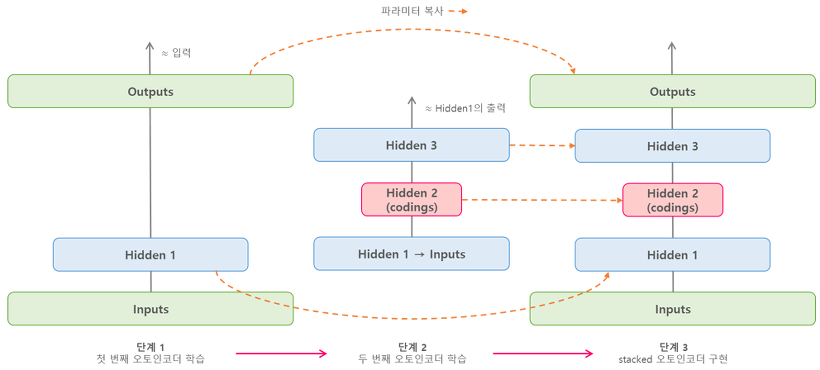

In [ ]:
def train_autoencoder(n_neurons, X_train, X_valid, loss, optimizer,
                      n_epochs=10, output_activation=None, metrics=None):
    n_inputs = X_train.shape[-1]
    encoder = keras.models.Sequential([
        keras.layers.Dense(n_neurons, activation="selu", input_shape=[n_inputs])
    ])
    decoder = keras.models.Sequential([
        keras.layers.Dense(n_inputs, activation=output_activation),
    ])
    autoencoder = keras.models.Sequential([encoder, decoder])
    autoencoder.compile(optimizer, loss, metrics=metrics)
    autoencoder.fit(X_train, X_train, epochs=n_epochs,
                    validation_data=(X_valid, X_valid))
    return encoder, decoder, encoder(X_train), encoder(X_valid)

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

K = keras.backend
X_train_flat = K.batch_flatten(X_train) 
X_valid_flat = K.batch_flatten(X_valid)
# 두개의 오토인코더 생성
enc1, dec1, X_train_enc1, X_valid_enc1 = train_autoencoder(
    100, X_train_flat, X_valid_flat, "binary_crossentropy",
    keras.optimizers.SGD(learning_rate=1.5), output_activation="sigmoid",
    metrics=[rounded_accuracy])
enc2, dec2, _, _ = train_autoencoder(
    30, X_train_enc1, X_valid_enc1, "mse", keras.optimizers.SGD(learning_rate=0.05),
    output_activation="selu")

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3445 - rounded_accuracy: 0.8874 - val_loss: 0.3123 - val_rounded_accuracy: 0.9146
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3039 - rounded_accuracy: 0.9203 - val_loss: 0.3006 - val_rounded_accuracy: 0.9246
Epoch 3/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2949 - rounded_accuracy: 0.9286 - val_loss: 0.2934 - val_rounded_accuracy: 0.9317
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2891 - rounded_accuracy: 0.9342 - val_loss: 0.2888 - val_rounded_accuracy: 0.9363
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2853 - rounded_accuracy: 0.9378 - val_loss: 0.2857 - val_rounded_accuracy: 0.9392
Epoch 6/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2827 - rounded_accuracy: 0.9403 - val_loss: 0.2834 - val_rounded_accuracy: 0.9409
Epoch 7/10
1719/1719 [==================

In [ ]:
# 오토인코더 적층
stacked_ae_1_by_1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    enc1, enc2, dec2, dec1,
    keras.layers.Reshape([28, 28])
])

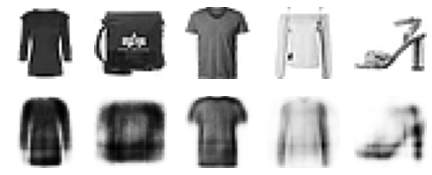

In [ ]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()

In [ ]:
stacked_ae_1_by_1.compile(loss="binary_crossentropy",
                          optimizer=keras.optimizers.SGD(learning_rate=0.1), metrics=[rounded_accuracy])
history = stacked_ae_1_by_1.fit(X_train, X_train, epochs=10,
                                validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2867 - rounded_accuracy: 0.9343 - val_loss: 0.2883 - val_rounded_accuracy: 0.9341
Epoch 2/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2863 - rounded_accuracy: 0.9347 - val_loss: 0.2881 - val_rounded_accuracy: 0.9347
Epoch 3/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2861 - rounded_accuracy: 0.9349 - val_loss: 0.2879 - val_rounded_accuracy: 0.9347
Epoch 4/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2859 - rounded_accuracy: 0.9351 - val_loss: 0.2877 - val_rounded_accuracy: 0.9349
Epoch 5/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2858 - rounded_accuracy: 0.9353 - val_loss: 0.2876 - val_rounded_accuracy: 0.9351
Epoch 6/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2857 - rounded_accuracy: 0.9354 - val_loss: 0.2874 - val_rounded_accuracy: 0.9350
Epoch 7/10
1719/1719 [==================

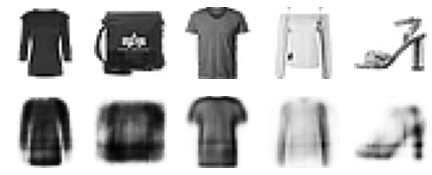

In [ ]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()